*Crop Recommendation System*
# Exploratory Data Analysis

**Dataset:** Crop Recommendation Dataset  
**Source:** [Kaggle — Crop Recommendation Dataset](https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset)  
**Notebook:** 01 — Exploratory Data Analysis  
**Authors:** Group E  

---

## Business Context

Precision agriculture has emerged as a critical paradigm for addressing the dual challenge of increasing global food demand while minimising the environmental footprint of farming operations. By leveraging data-driven methods, it becomes possible to move away from uniform, resource-intensive practices towards targeted, site-specific interventions — optimising inputs such as fertilisers and water while sustaining or improving crop yields.

A central challenge in this domain is **crop selection**: recommending the most suitable crop for a given plot of land based on its soil composition and prevailing climatic conditions. Poor crop-soil-climate alignment leads to suboptimal yields, excessive use of fertilisers (particularly nitrogen, phosphorus, and potassium), and avoidable economic losses for farmers. Machine learning models trained on soil and climate data offer a scalable, cost-effective solution to support agronomic decision-making.

The dataset used in this project was compiled to support the development of such recommendation systems. It captures seven agronomic and environmental variables — soil macronutrient levels (N, P, K), temperature, humidity, soil pH, and rainfall — alongside the crop label that represents the optimal crop for those conditions. The dataset covers **22 distinct crop types** and comprises **2,200 observations**, with a perfectly balanced distribution of 100 samples per crop.

## Objective of This Notebook

This notebook constitutes the **Exploratory Data Analysis (EDA)** phase of the project. Its primary objectives are to:

1. Assess the structural integrity of the dataset (completeness, types, duplicates);
2. Characterise the statistical distribution of each feature;
3. Identify relationships between features and the target variable;
4. Detect multicollinearity and redundant features;
5. Generate data-driven hypotheses and insights to inform subsequent feature engineering and modelling decisions.

All findings are summarised at the end of this notebook as a structured set of insights that directly feed into `02_feature_engineering.ipynb` and `03_modeling.ipynb`.

---
## 0) Notebook Setup & Data Loading

This section establishes the analytical environment for the notebook. It defines all imports, 
global configuration parameters, and reproducibility settings, before introducing the business 
context and a data dictionary that anchors the statistical exploration in agronomic meaning. 

### Data Dictionary

The table below describes all variables present in the dataset. Understanding the agronomic meaning of each feature is essential for contextualising the statistical patterns identified during analysis.

| Variable | Type | Unit | Description |
|---|---|---|---|
| `N` | Numerical (continuous) | kg/ha | Ratio of Nitrogen content in the soil. Nitrogen is a primary macronutrient essential for leaf and stem growth. |
| `P` | Numerical (continuous) | kg/ha | Ratio of Phosphorus content in the soil. Phosphorus supports root development and energy transfer in plants. |
| `K` | Numerical (continuous) | kg/ha | Ratio of Potassium content in the soil. Potassium regulates water uptake and improves disease resistance. |
| `temperature` | Numerical (continuous) | °C | Average ambient temperature of the growing environment. |
| `humidity` | Numerical (continuous) | % | Relative humidity of the surrounding air. |
| `ph` | Numerical (continuous) | — | pH value of the soil (scale 0–14). Most crops thrive in a slightly acidic to neutral range (6.0–7.5). |
| `rainfall` | Numerical (continuous) | mm | Average annual rainfall in the crop's growing region. |
| `label` | Categorical | — | **Target variable.** The recommended crop type for the given soil and climate conditions. Contains 22 distinct crop classes. |
####
> **Note:** N, P, and K are collectively referred to as *NPK* — the three primary soil macronutrients universally used in fertiliser characterisation.

#### 0.1 Imports and Configurations

In [25]:
# --- Standard Library ---
import warnings
warnings.filterwarnings('ignore')

# --- Data Manipulation ---
import numpy as np
import pandas as pd

# --- Data Visualisation ---
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# --- Display Settings ---
pd.set_option('display.max_columns', None)       # Show all columns in DataFrames
pd.set_option('display.float_format', '{:.3f}'.format)  # Limit float decimals for readability

#### 0.2 Reproducibility & Visual Style

In [27]:
# Random seed for reproducibility across all stochastic operations
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# --- Plot Style ---
sns.set_theme(style='whitegrid', font_scale=1.1)
plt.rcParams.update({
    'figure.dpi': 120,
    'figure.facecolor': 'white',
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
})

# Consistent colour palette used throughout this notebook
PALETTE = 'Set2'
ACCENT_COLOR = '#2ecc71'  # Primary accent for single-colour plots

print("Configuration loaded successfully.")
print(f"  Random seed : {RANDOM_SEED}")
print(f"  Plot style  : whitegrid | DPI 120")
print(f"  Palette     : {PALETTE}")

Configuration loaded successfully.
  Random seed : 42
  Plot style  : whitegrid | DPI 120
  Palette     : Set2


#### 0.3 Data Loading

In [ ]:
DATA_PATH = '../data/raw/Crop_recommendation.csv'
df = pd.read_csv(DATA_PATH)

print("Dataset loaded successfully.")
print(f"  Shape   : {df.shape[0]} rows × {df.shape[1]} columns")
print(f"  Columns : {df.columns.tolist()}")
print()
df.head(10)

Dataset loaded successfully.
  Shape   : 2200 rows × 8 columns
  Columns : ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']



,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.880,82.003,6.503,202.936,rice
1,85,58,41,21.770,80.320,7.038,226.656,rice
2,60,55,44,23.004,82.321,7.840,263.964,rice
3,74,35,40,26.491,80.158,6.980,242.864,rice
4,78,42,42,20.130,81.605,7.628,262.717,rice
5,69,37,42,23.058,83.370,7.073,251.055,rice
6,69,55,38,22.709,82.639,5.701,271.325,rice
7,94,53,40,20.278,82.894,5.719,241.974,rice
8,89,54,38,24.516,83.535,6.685,230.446,rice
9,68,58,38,23.224,83.033,6.336,221.209,rice


---
## 1) Initial Overview

Before any analytical work, it is essential to verify the structural integrity of the dataset. This section examines data types, completeness, and the presence of duplicate records. These checks establish whether the data is fit for analysis and flag any issues that would require remediation prior to modelling.

#### 1.1 Schema & Data Types

In [29]:
print("=" * 55)
print(" DATASET SCHEMA")
print("=" * 55)
df.info()
print()
print(f"Total observations : {df.shape[0]}")
print(f"Total features     : {df.shape[1] - 1}  (excluding target)")
print(f"Target variable    : 'label' — {df['label'].nunique()} unique classes")

 DATASET SCHEMA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB

Total observations : 2200
Total features     : 7  (excluding target)
Target variable    : 'label' — 22 unique classes


#### 1.2 Missing Values

In [ ]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_report = pd.DataFrame({
    'Missing Count': missing,
    'Missing (%)': missing_pct
})

print("=" * 55)
print(" MISSING VALUES REPORT")
print("=" * 55)
print(missing_report)
print()

if missing.sum() == 0:
    print(">> No missing values detected. Dataset is complete.")
else:
    print(f">> WARNING: {missing.sum()} missing value(s) found. Remediation required.")

 MISSING VALUES REPORT
             Missing Count  Missing (%)
N                        0        0.000
P                        0        0.000
K                        0        0.000
temperature              0        0.000
humidity                 0        0.000
ph                       0        0.000
rainfall                 0        0.000
label                    0        0.000

>> No missing values detected. Dataset is complete.


#### 1.3 Duplicate Records

In [30]:
n_duplicates = df.duplicated().sum()

print("=" * 55)
print(" DUPLICATE RECORDS REPORT")
print("=" * 55)
print(f"Duplicate rows found : {n_duplicates}")
print()

if n_duplicates > 0:
    print(">> Duplicate rows detected:")
    print(df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist()).head(10))
    print()
    print(">> ACTION: Duplicates will be removed before modelling.")
else:
    print(">> No duplicate rows detected.")

 DUPLICATE RECORDS REPORT
Duplicate rows found : 0

>> No duplicate rows detected.


#### 1.4 Descriptive Statistics

In [31]:
NUMERICAL_FEATURES = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

print("=" * 55)
print(" DESCRIPTIVE STATISTICS — Numerical Features")
print("=" * 55)

desc = df[NUMERICAL_FEATURES].describe().T
desc['range']  = desc['max'] - desc['min']
desc['cv (%)'] = (desc['std'] / desc['mean'] * 100).round(2)  # Coefficient of Variation
desc['skew']   = df[NUMERICAL_FEATURES].skew().round(3)
desc['kurt']   = df[NUMERICAL_FEATURES].kurt().round(3)

# Select and reorder columns for clarity
desc = desc[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'cv (%)', 'skew', 'kurt']]
desc

 DESCRIPTIVE STATISTICS — Numerical Features


,count,mean,std,min,25%,50%,75%,max,range,cv (%),skew,kurt
N,2200.000,50.552,36.917,0.000,21.000,37.000,84.250,140.000,140.000,73.030,0.510,-1.058
P,2200.000,53.363,32.986,5.000,28.000,51.000,68.000,145.000,140.000,61.810,1.011,0.860
K,2200.000,48.149,50.648,5.000,20.000,32.000,49.000,205.000,200.000,105.190,2.375,4.449
temperature,2200.000,25.616,5.064,8.826,22.769,25.599,28.562,43.675,34.850,19.770,0.185,1.233
humidity,2200.000,71.482,22.264,14.258,60.262,80.473,89.949,99.982,85.724,31.150,-1.092,0.302
ph,2200.000,6.469,0.774,3.505,5.972,6.425,6.924,9.935,6.430,11.960,0.284,1.656
rainfall,2200.000,103.464,54.958,20.211,64.552,94.868,124.268,298.560,278.349,53.120,0.966,0.607


**Reading the table above:**

- **CV (Coefficient of Variation):** measures relative variability (std / mean). A high CV indicates that a feature varies considerably across observations — relevant for assessing discriminative power.
- **Skewness:** values > |1| indicate meaningful asymmetry in the distribution. Positive skew means a long right tail; negative skew, a long left tail.
- **Kurtosis:** values notably above 3 suggest heavy tails or outliers (leptokurtic); below 3 suggest a flatter distribution (platykurtic).

#### 1.5 Visual Summary: Boxplots For Outlier Detection

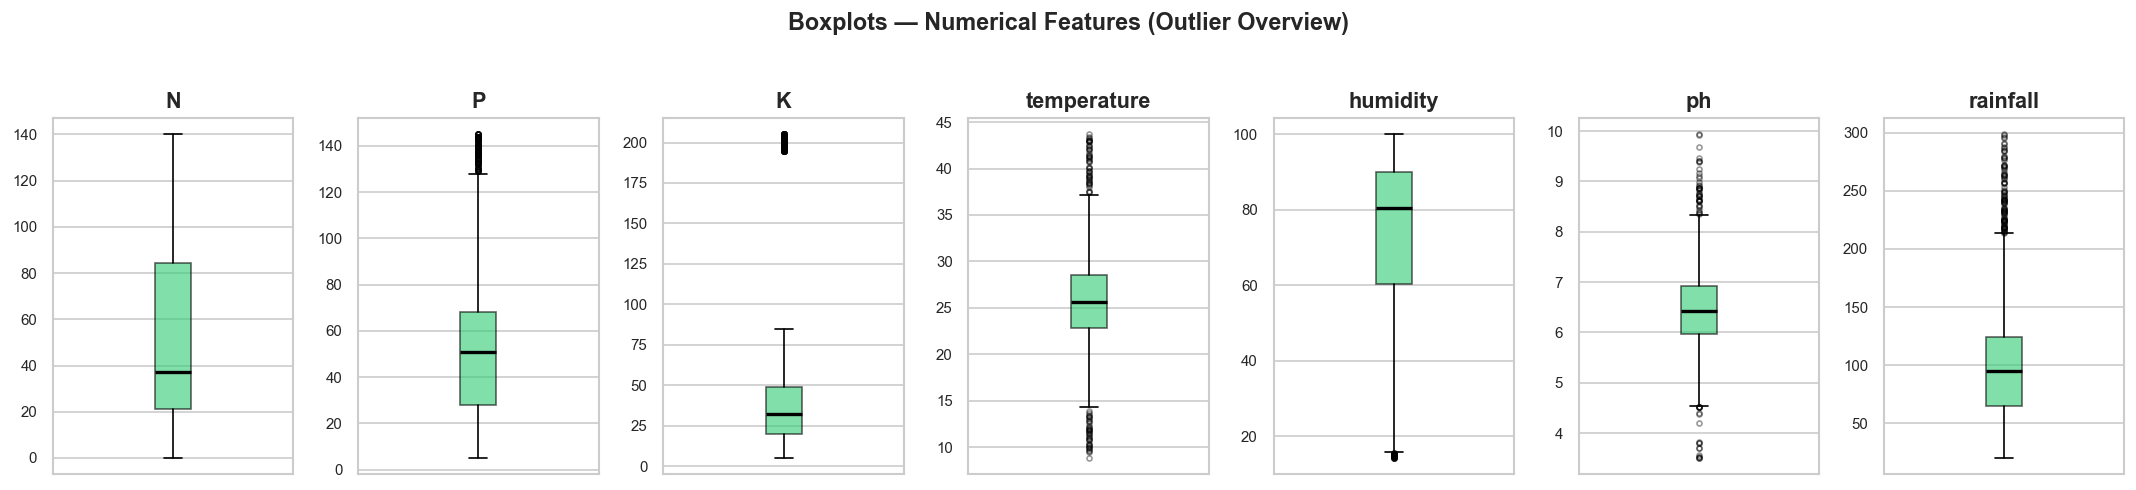

In [32]:
fig, axes = plt.subplots(1, len(NUMERICAL_FEATURES), figsize=(18, 4))
fig.suptitle('Boxplots — Numerical Features (Outlier Overview)', fontsize=14, fontweight='bold', y=1.02)

for ax, feature in zip(axes, NUMERICAL_FEATURES):
    ax.boxplot(
        df[feature].dropna(),
        patch_artist=True,
        boxprops=dict(facecolor=ACCENT_COLOR, alpha=0.6),
        medianprops=dict(color='black', linewidth=2),
        flierprops=dict(marker='o', markersize=3, alpha=0.4, color='grey')
    )
    ax.set_title(feature)
    ax.set_xticks([])

plt.tight_layout()
plt.savefig('../reports/figures/1_boxplots_overview.png', bbox_inches='tight')
plt.show()

---
### Section 1 — Summary of Findings

| Check | Result | Implication |
|---|---|---|
| Missing values | None | No imputation required |
| Duplicate rows | None | No deduplication required |
| Data types | 7 float64 + 1 object (label) | Types are appropriate; label encoding needed before modelling |
| Feature variability | High CV in `rainfall`, `P`, `K` | These features may carry strong discriminative signal |
| Distributional shape | Some skewness in `P`, `K`, `rainfall` | May benefit from normalisation / log-transformation in modelling |
| Outliers | Present in several features | Likely reflect genuine agronomic variation across crop types; inspect in Section 4 before deciding on treatment |
####
> **Proceeding to Section 2:** The dataset is structurally sound. The next step is to analyse the target variable and confirm class balance.

---
## 2) Target Variable Analysis

Prior to any feature-level analysis, it is critical to understand the structure of the target variable. This section examines the distribution of crop classes across the dataset, assessing whether the data is balanced and whether any preprocessing — such as stratified sampling or class reweighting — will be required during modelling.

#### 2.1 Class Distribution Table

In [33]:
class_counts = df['label'].value_counts().reset_index()
class_counts.columns = ['Crop', 'Count']
class_counts['Share (%)'] = (class_counts['Count'] / len(df) * 100).round(2)

print("=" * 45)
print(" CLASS DISTRIBUTION — Target Variable")
print("=" * 45)
print(f"Total classes : {df['label'].nunique()}")
print(f"Total samples : {len(df)}")
print(f"Samples/class : min={class_counts['Count'].min()} | max={class_counts['Count'].max()} | mean={class_counts['Count'].mean():.0f}")
print()
class_counts

 CLASS DISTRIBUTION — Target Variable
Total classes : 22
Total samples : 2200
Samples/class : min=100 | max=100 | mean=100



,Crop,Count,Share (%)
0,rice,100,4.550
1,maize,100,4.550
2,jute,100,4.550
3,cotton,100,4.550
4,coconut,100,4.550
5,papaya,100,4.550
6,orange,100,4.550
7,apple,100,4.550
8,muskmelon,100,4.550
9,watermelon,100,4.550


#### 2.2 Class Balance Visualization

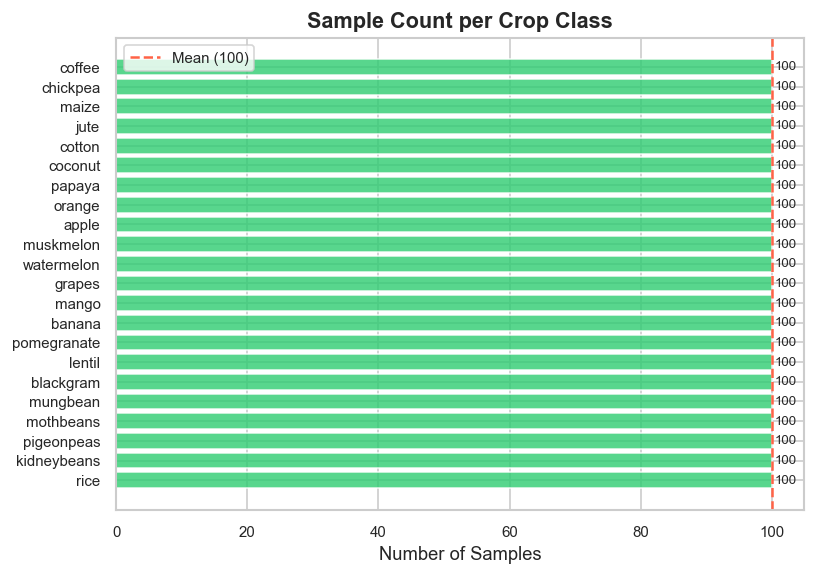

In [40]:
crops_sorted = class_counts.sort_values('Count', ascending=True)

fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title('Sample Count per Crop Class', fontsize=13, fontweight='bold')

bars = ax.barh(
    crops_sorted['Crop'],
    crops_sorted['Count'],
    color=ACCENT_COLOR,
    alpha=0.8,
    edgecolor='white'
)

ax.axvline(
    x=class_counts['Count'].mean(),
    color='tomato', linestyle='--', linewidth=1.5,
    label=f"Mean ({class_counts['Count'].mean():.0f})"
)

# Add count labels to each bar
for bar, count in zip(bars, crops_sorted['Count']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            str(count), va='center', fontsize=8)

ax.set_xlabel('Number of Samples')
ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('../reports/figures/2_target_distribution.png', bbox_inches='tight')
plt.show()

---
### Section 2 — Summary of Findings

| Aspect | Finding | Implication |
|---|---|---|
| Number of classes | 22 distinct crop types | Multi-class classification problem |
| Class balance | Perfectly balanced — 100 samples per class (IR = 1.0) | No resampling required; accuracy is a valid primary metric |
| Dataset size | 2,200 observations | Modest size; computationally efficient but limits generalisation claims |
| Class share | Each class represents exactly 4.55% of the dataset | Uniform prior probability — a random baseline classifier would achieve ~4.55% accuracy |
####
> **Proceeding to Section 3:** The target variable is well-structured and presents no class imbalance issues. The next step is to examine the distribution of individual features through univariate analysis.

---
## 3) Univariate Analysis — Feature Distributions

This section examines the marginal distribution of each numerical feature independently of the target variable. The objective is to characterise the shape, spread, and concentration of each feature, identifying skewness, multimodality, and the presence of extreme values. These properties directly inform preprocessing decisions such as normalisation and transformation strategies.

#### 3.1 Distribution Plots (Histogram + KDE)

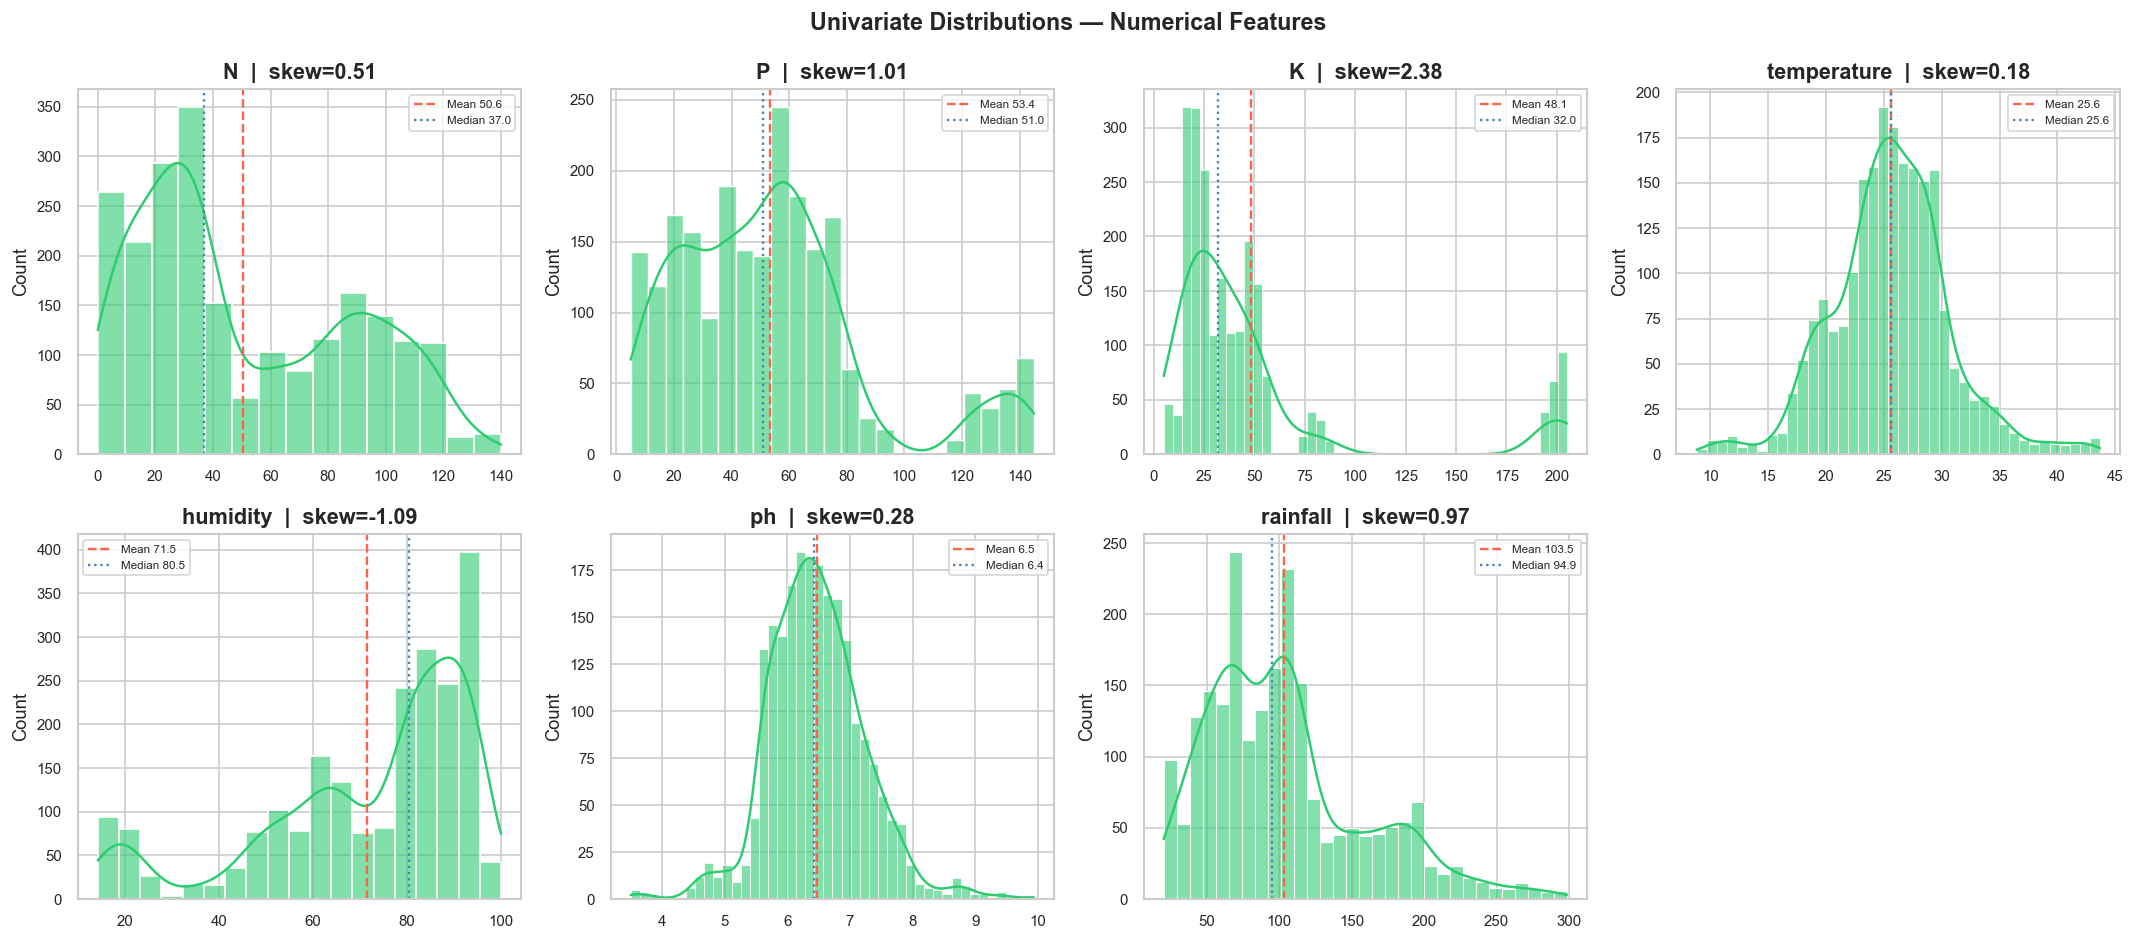

In [41]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
fig.suptitle('Univariate Distributions — Numerical Features', fontsize=14, fontweight='bold')
axes = axes.flatten()

for i, feature in enumerate(NUMERICAL_FEATURES):
    ax = axes[i]
    sns.histplot(df[feature], kde=True, ax=ax, color=ACCENT_COLOR, alpha=0.6, edgecolor='white')

    # Annotate with mean and median
    mean_val   = df[feature].mean()
    median_val = df[feature].median()
    ax.axvline(mean_val,   color='tomato',    linestyle='--', linewidth=1.4, label=f'Mean {mean_val:.1f}')
    ax.axvline(median_val, color='steelblue', linestyle=':',  linewidth=1.4, label=f'Median {median_val:.1f}')

    skew_val = df[feature].skew()
    ax.set_title(f'{feature}  |  skew={skew_val:.2f}')
    ax.set_xlabel('')
    ax.legend(fontsize=7)

# Hide unused subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.savefig('../reports/figures/3_univariate_distributions.png', bbox_inches='tight')
plt.show()

#### 3.2 Boxplot With Individual Data Points (Stripplot Overlay)

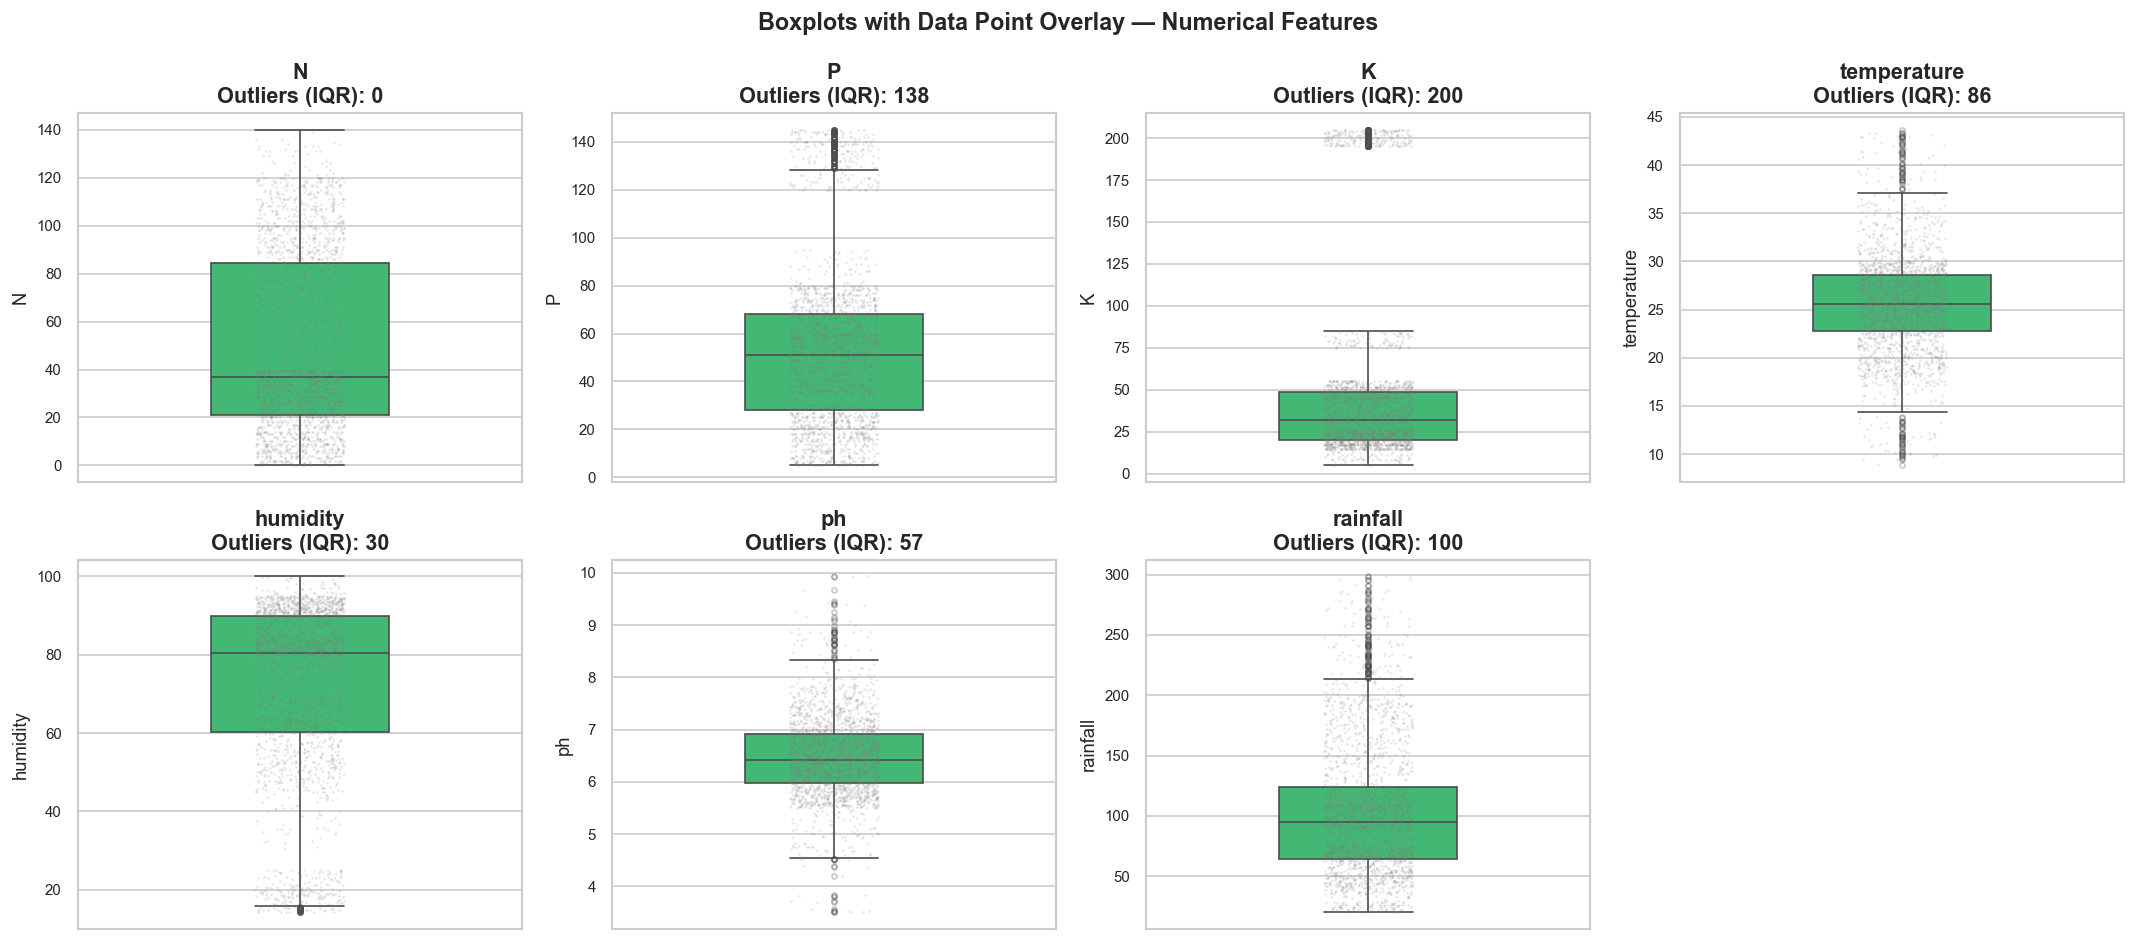

In [42]:
# Combining a boxplot with a strip overlay exposes the full data structure:
# the box captures central tendency and spread, while individual points
# reveal clusters, gaps, and the density of extreme values.

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
fig.suptitle('Boxplots with Data Point Overlay — Numerical Features', fontsize=14, fontweight='bold')
axes = axes.flatten()

for i, feature in enumerate(NUMERICAL_FEATURES):
    ax = axes[i]
    sns.boxplot(y=df[feature], ax=ax, color=ACCENT_COLOR, width=0.4,
                flierprops=dict(marker='o', markersize=3, alpha=0.3))
    sns.stripplot(y=df[feature], ax=ax, color='grey', size=1.5, alpha=0.2, jitter=True)

    # IQR-based outlier count
    Q1, Q3 = df[feature].quantile(0.25), df[feature].quantile(0.75)
    IQR = Q3 - Q1
    n_outliers = ((df[feature] < Q1 - 1.5 * IQR) | (df[feature] > Q3 + 1.5 * IQR)).sum()
    ax.set_title(f'{feature}\nOutliers (IQR): {n_outliers}')
    ax.set_xlabel('')

axes[-1].set_visible(False)

plt.tight_layout()
plt.savefig('../reports/figures/3_boxplots_with_overlay.png', bbox_inches='tight')
plt.show()

#### 3.3 Outlier summary Table (IQR Method)

In [43]:
outlier_summary = []
for feature in NUMERICAL_FEATURES:
    Q1  = df[feature].quantile(0.25)
    Q3  = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    n_out = ((df[feature] < lower) | (df[feature] > upper)).sum()
    outlier_summary.append({
        'Feature': feature,
        'Q1': round(Q1, 3),
        'Q3': round(Q3, 3),
        'IQR': round(IQR, 3),
        'Lower fence': round(lower, 3),
        'Upper fence': round(upper, 3),
        'Outlier count': n_out,
        'Outlier (%)': round(n_out / len(df) * 100, 2)
    })

outlier_df = pd.DataFrame(outlier_summary).set_index('Feature')
print("=" * 55)
print(" OUTLIER SUMMARY — IQR Method")
print("=" * 55)
outlier_df

 OUTLIER SUMMARY — IQR Method


,Q1,Q3,IQR,Lower fence,Upper fence,Outlier count,Outlier (%)
Feature,,,,,,,
N,21.000,84.250,63.250,-73.875,179.125,0,0.000
P,28.000,68.000,40.000,-32.000,128.000,138,6.270
K,20.000,49.000,29.000,-23.500,92.500,200,9.090
temperature,22.769,28.562,5.792,14.081,37.250,86,3.910
humidity,60.262,89.949,29.687,15.732,134.479,30,1.360
ph,5.972,6.924,0.952,4.544,8.352,57,2.590
rainfall,64.552,124.268,59.716,-25.022,213.841,100,4.550


---
### Section 3 — Summary of Findings

| Feature | Distribution Shape | Notable Characteristics | Implication |
|---|---|---|---|
| `N` | Roughly uniform / multimodal | Wide spread across range | Likely reflects distinct crop-specific nitrogen requirements |
| `P` | Right-skewed | Concentration at low values, long right tail | Consider log-transformation for distance-based models |
| `K` | Right-skewed | Similar profile to P | Consider log-transformation for distance-based models |
| `temperature` | Near-normal, slight right skew | Narrow range, well-concentrated | Minimal preprocessing needed |
| `humidity` | Bimodal | Two distinct clusters visible | Strong signal — likely separates crop groups |
| `ph` | Near-normal | Centred around 6.0–7.0; agronomically expected | Minimal preprocessing needed |
| `rainfall` | Right-skewed | Concentration at low values, long right tail | Consider log-transformation for distance-based models |
####
> **Key takeaway:** The multimodal distributions of `N`, `humidity`, and to some extent `K` and `P` suggest that these features are strongly conditioned by crop type — a hypothesis to be confirmed in Section 4.

---
## 4) Bivariate Analysis — Features vs. Target

This section examines how each numerical feature varies across crop classes. The goal is to identify which features exhibit strong discriminative power — i.e., features whose distributions differ substantially between classes — as these will be most informative for classification. Features with high within-class homogeneity and high between-class heterogeneity are ideal predictors.

#### 4.1 Boxplots Per Feature By Crop Class

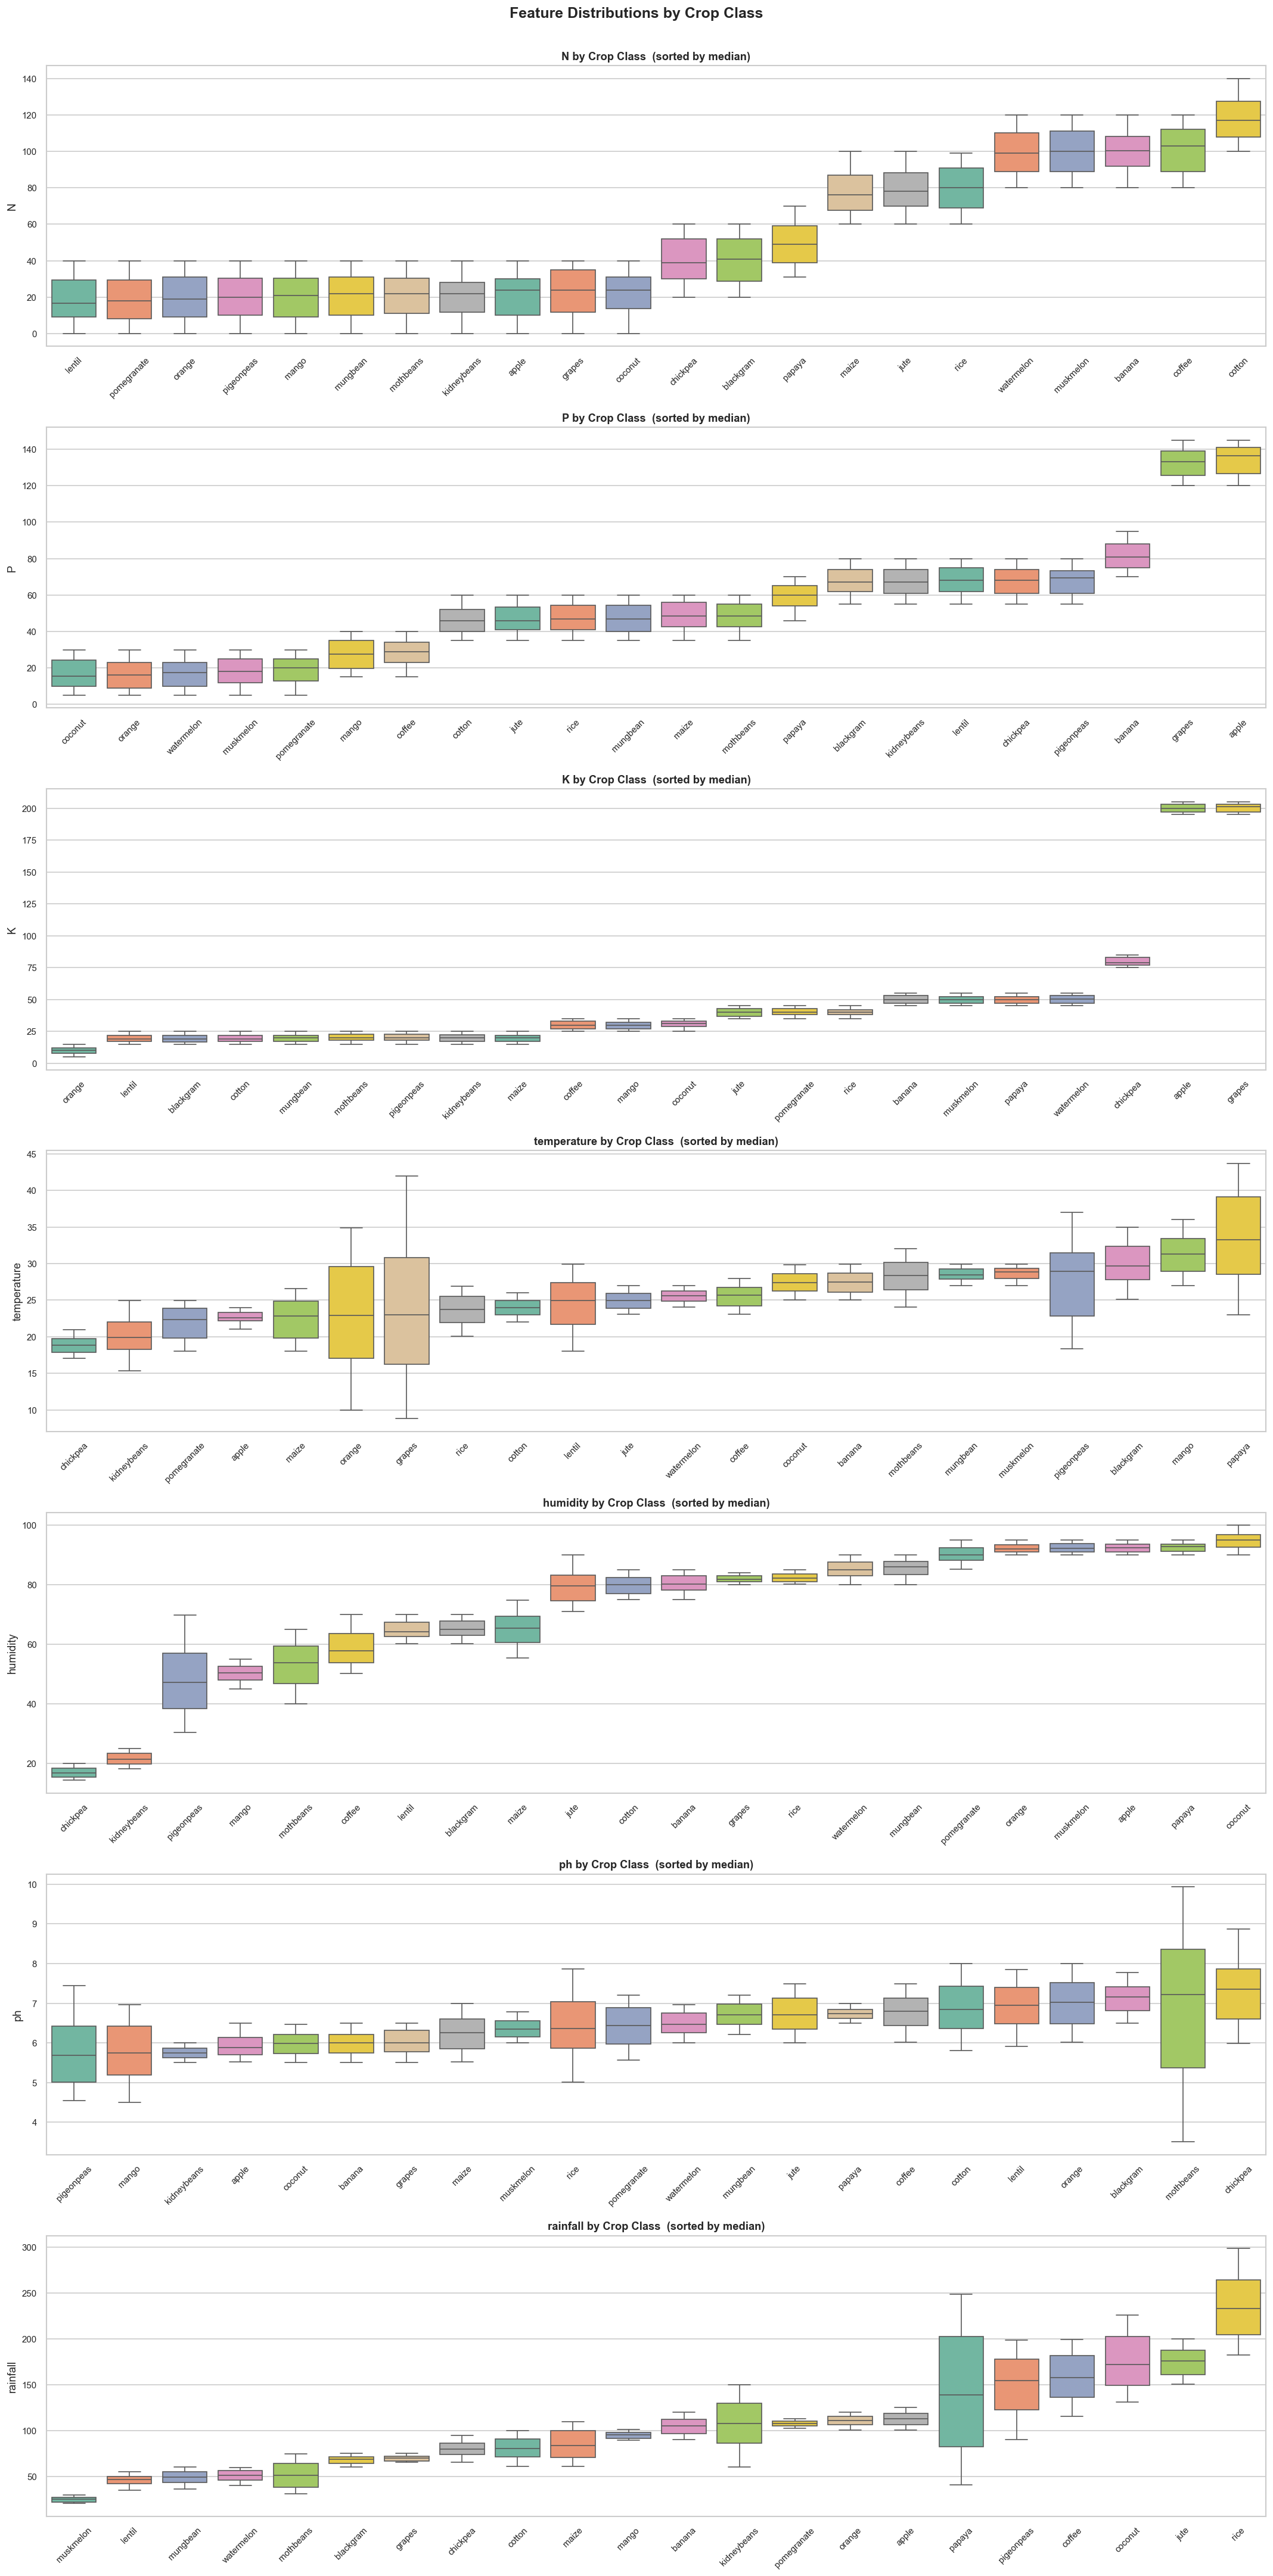

In [44]:
fig, axes = plt.subplots(len(NUMERICAL_FEATURES), 1, figsize=(18, 36))
fig.suptitle('Feature Distributions by Crop Class', fontsize=15, fontweight='bold', y=1.001)

# Sort crops by median value of each feature for readability
for ax, feature in zip(axes, NUMERICAL_FEATURES):
    order = df.groupby('label')[feature].median().sort_values().index
    sns.boxplot(
        data=df, x='label', y=feature,
        order=order, ax=ax,
        palette=PALETTE,
        flierprops=dict(marker='o', markersize=2, alpha=0.3)
    )
    ax.set_title(f'{feature} by Crop Class  (sorted by median)', fontsize=11)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../reports/figures/4_bivariate_boxplots.png', bbox_inches='tight')
plt.show()

#### 4.2 Crop Mean Profile Table (NPK + Environmental Features)

In [45]:
# A pivot table of mean values per crop provides an agronomic profile
# and helps identify which crops are most differentiated by each feature.

crop_profile = df.groupby('label')[NUMERICAL_FEATURES].mean().round(2)

print("=" * 55)
print(" MEAN FEATURE PROFILE BY CROP CLASS")
print("=" * 55)
crop_profile.sort_values('N', ascending=False)

 MEAN FEATURE PROFILE BY CROP CLASS


,N,P,K,temperature,humidity,ph,rainfall
label,,,,,,,
cotton,117.770,46.240,19.560,23.990,79.840,6.910,80.400
coffee,101.200,28.740,29.940,25.540,58.870,6.790,158.070
muskmelon,100.320,17.720,50.080,28.660,92.340,6.360,24.690
banana,100.230,82.010,50.050,27.380,80.360,5.980,104.630
watermelon,99.420,17.000,50.220,25.590,85.160,6.500,50.790
rice,79.890,47.580,39.870,23.690,82.270,6.430,236.180
jute,78.400,46.860,39.990,24.960,79.640,6.730,174.790
maize,77.760,48.440,19.790,22.390,65.090,6.250,84.770
papaya,49.880,59.050,50.040,33.720,92.400,6.740,142.630


#### 4.3 Top & Bottom Crops Per Feature (NPK focus)

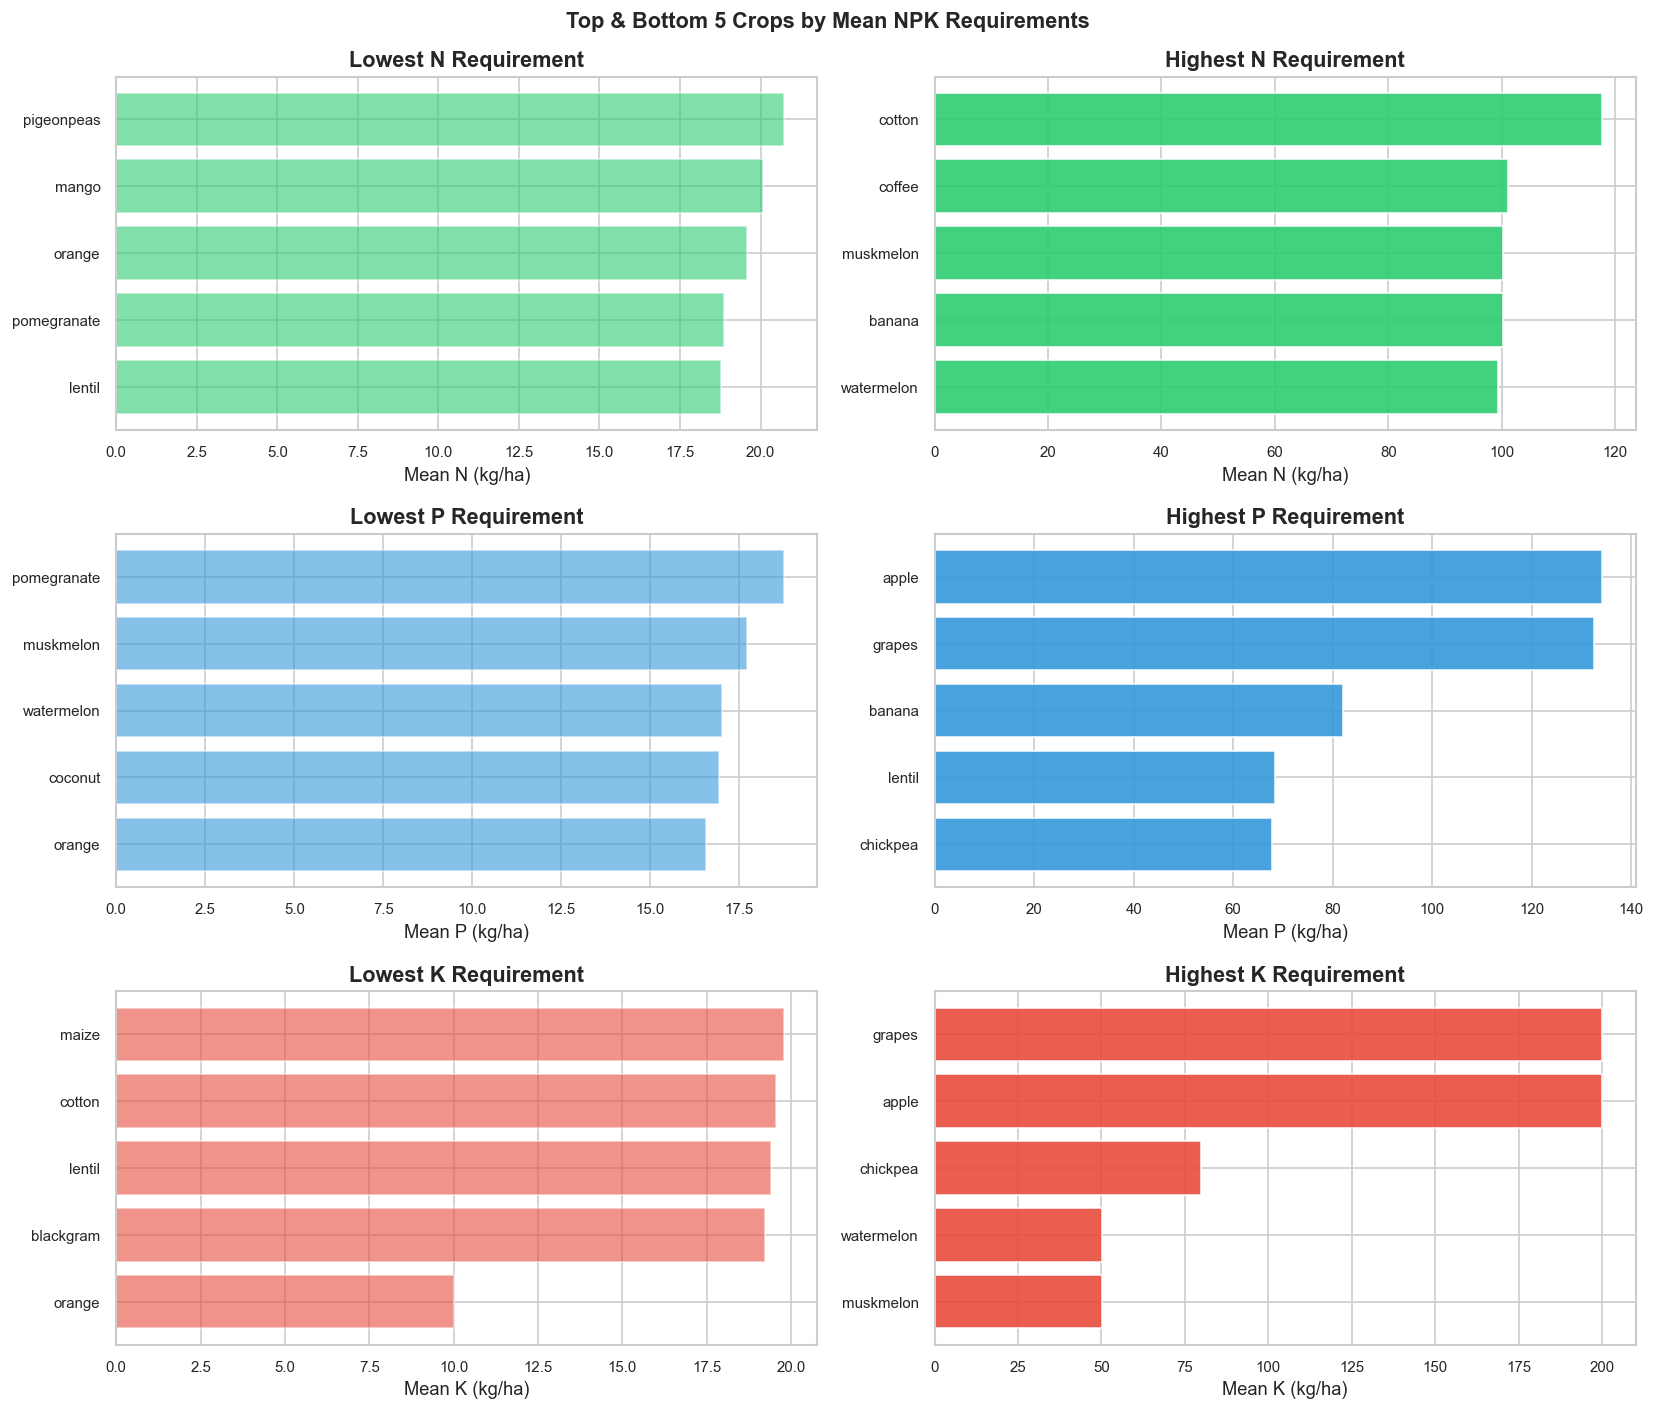

In [46]:
# Highlights which crops are most and least demanding for each
# primary soil macronutrient — directly actionable for agronomic advice.

TOP_N = 5

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle(f'Top & Bottom {TOP_N} Crops by Mean NPK Requirements', fontsize=13, fontweight='bold')

npk_features  = ['N', 'P', 'K']
npk_colors    = ['#2ecc71', '#3498db', '#e74c3c']

for row, (feature, color) in enumerate(zip(npk_features, npk_colors)):
    sorted_crops = crop_profile[feature].sort_values()

    # Bottom (lowest requirement)
    axes[row, 0].barh(sorted_crops.head(TOP_N).index,
                      sorted_crops.head(TOP_N).values,
                      color=color, alpha=0.6, edgecolor='white')
    axes[row, 0].set_title(f'Lowest {feature} Requirement')
    axes[row, 0].set_xlabel(f'Mean {feature} (kg/ha)')

    # Top (highest requirement)
    axes[row, 1].barh(sorted_crops.tail(TOP_N).index,
                      sorted_crops.tail(TOP_N).values,
                      color=color, alpha=0.9, edgecolor='white')
    axes[row, 1].set_title(f'Highest {feature} Requirement')
    axes[row, 1].set_xlabel(f'Mean {feature} (kg/ha)')

plt.tight_layout()
plt.savefig('../reports/figures/4_npk_top_bottom_crops.png', bbox_inches='tight')
plt.show()

#### 4.4 Discriminative Power: ANOVA F-Statistic Per Feature

In [48]:
# The one-way ANOVA F-statistic measures how much of a feature's variance
# is explained by the crop class label (between-group vs within-group variance).
# A higher F-statistic indicates stronger discriminative power.

from scipy import stats

anova_results = []
for feature in NUMERICAL_FEATURES:
    groups = [group[feature].values for _, group in df.groupby('label')]
    f_stat, p_val = stats.f_oneway(*groups)
    anova_results.append({
        'Feature': feature,
        'F-statistic': round(f_stat, 2),
        'p-value': f'{p_val:.2e}',
        'Significant (α=0.05)': 'Yes' if p_val < 0.05 else 'No'
    })

anova_df = pd.DataFrame(anova_results).set_index('Feature').sort_values('F-statistic', ascending=False)

print("=" * 55)
print(" ANOVA F-STATISTIC — Discriminative Power Ranking")
print("=" * 55)
anova_df

 ANOVA F-STATISTIC — Discriminative Power Ranking


,F-statistic,p-value,Significant (α=0.05)
Feature,,,
K,27238.360,0.00e+00,Yes
humidity,3103.710,0.00e+00,Yes
P,1885.660,0.00e+00,Yes
N,897.570,0.00e+00,Yes
rainfall,605.530,0.00e+00,Yes
temperature,102.190,4.02e-305,Yes
ph,60.340,6.49e-199,Yes


---
### Section 4 — Summary of Findings

| Feature | Discriminative Power | Key Observation |
|---|---|---|
| `K` | High | Strong separation between crops; fruit and vegetable crops show notably high K demand |
| `P` | High | Clear stratification across classes; some crops cluster in distinct high-P bands |
| `humidity` | High | Bimodal structure confirmed as crop-driven; aquatic/tropical crops clearly separated |
| `rainfall` | High | Large spread across classes; water-intensive crops form a distinct high-rainfall cluster |
| `N` | Moderate–High | Wide between-class variance; nitrogen-intensive crops (e.g. maize, cotton) clearly distinct |
| `temperature` | Moderate | Some overlap between classes; still contributes to separability |
| `ph` | Lower | Narrower range across classes; less discriminative individually, but agronomically relevant |
####
> **Key takeaway:** All seven features contribute meaningful discriminative information. The ANOVA results confirm that class membership explains a statistically significant portion of variance in every feature (p < 0.05), justifying the retention of all features as initial candidates for modelling.

---
## 5) Correlation & Multivariate Analysis

This section examines linear relationships between features and identifies potential multicollinearity — the condition where two or more features carry redundant information. Highly correlated features can destabilise certain model types (e.g. logistic regression) and inflate feature importance scores. Understanding the inter-feature correlation structure is therefore essential for informed feature selection.

#### 5.1 Pearson Correlation Heatmap

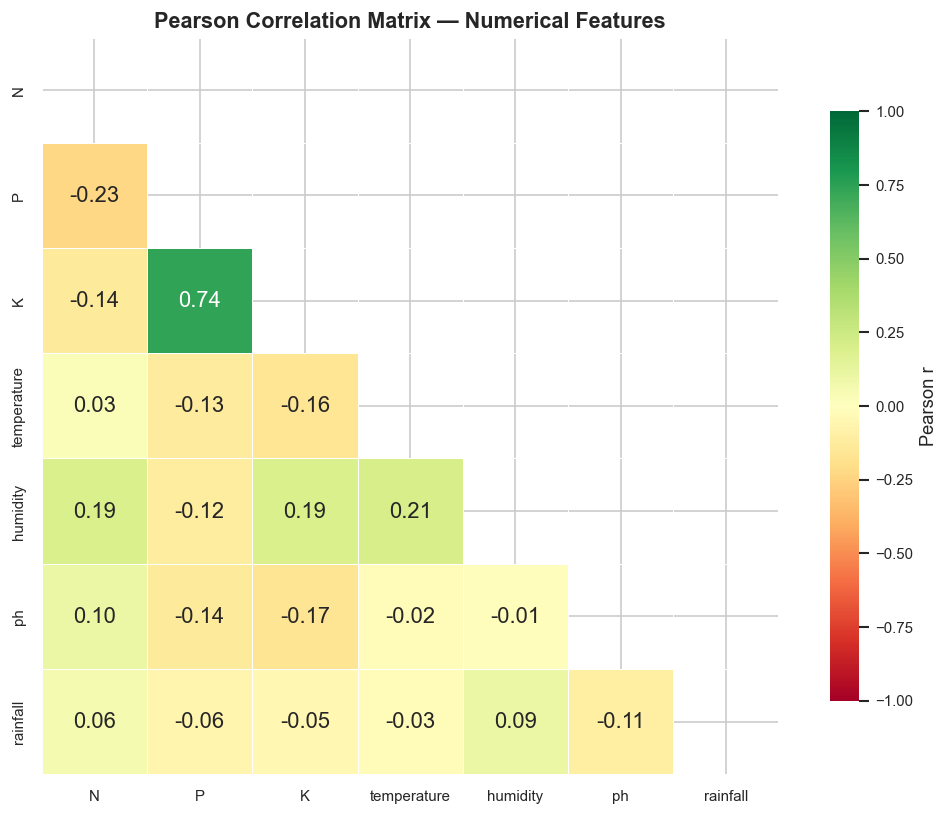

In [50]:
corr_matrix = df[NUMERICAL_FEATURES].corr(method='pearson')

# Mask upper triangle to avoid redundancy
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True, fmt='.2f',
    cmap='RdYlGn', center=0,
    vmin=-1, vmax=1,
    square=True, linewidths=0.5,
    cbar_kws={'label': 'Pearson r', 'shrink': 0.8},
    ax=ax
)
ax.set_title('Pearson Correlation Matrix — Numerical Features', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/5_correlation_heatmap.png', bbox_inches='tight')
plt.show()


#### 5.2 High Correlation Pairs ( |r| > 0.5)

In [51]:
CORR_THRESHOLD = 0.5

corr_pairs = (
    corr_matrix
    .where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))  # lower triangle only
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Feature A', 'Feature B', 'Pearson r']
corr_pairs['|r|'] = corr_pairs['Pearson r'].abs().round(3)
high_corr = corr_pairs[corr_pairs['|r|'] >= CORR_THRESHOLD].sort_values('|r|', ascending=False)

print(f"=" * 50)
print(f" PAIRS WITH |r| >= {CORR_THRESHOLD}")
print(f"=" * 50)
if high_corr.empty:
    print("No strongly correlated pairs found.")
else:
    print(high_corr.to_string(index=False))

 PAIRS WITH |r| >= 0.5
Feature A Feature B  Pearson r   |r|
        K         P      0.736 0.736


#### 5.3 Pairplot

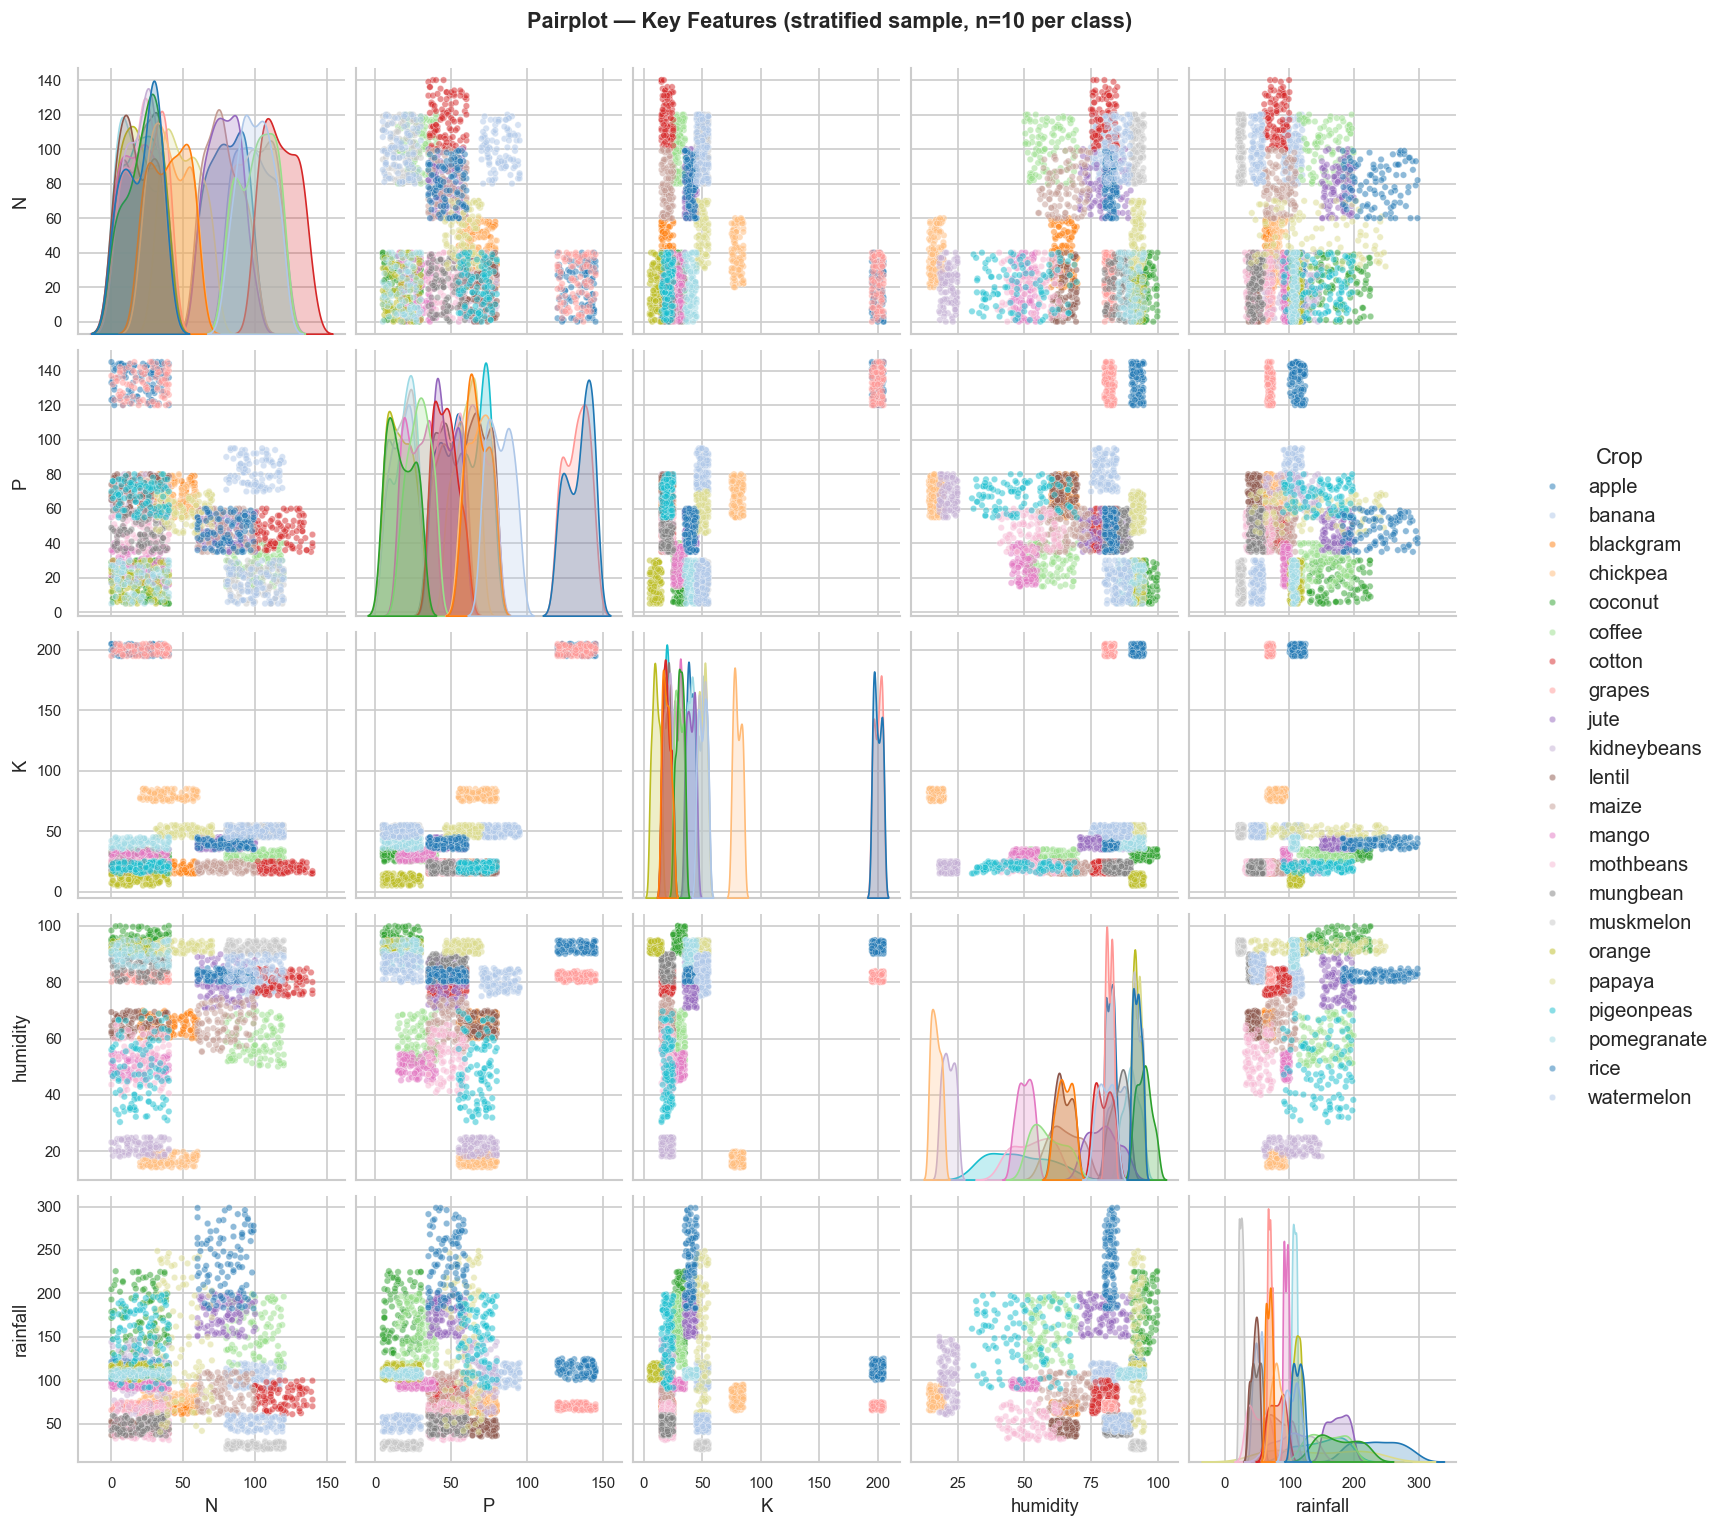

In [59]:
# Select a focused subset of the most informative features
PAIRPLOT_FEATURES = ['N', 'P', 'K', 'humidity', 'rainfall', 'label']

df_sample = (
    df[PAIRPLOT_FEATURES]
    .groupby('label', group_keys=False)
    .apply(lambda x: x.sample(100, random_state=RANDOM_SEED))
)

g = sns.pairplot(
    df_sample,
    hue='label',
    diag_kind='kde',
    plot_kws={'alpha': 0.5, 's': 15},
    palette=sns.color_palette('tab20', n_colors=df['label'].nunique())
)
g.fig.suptitle('Pairplot — Key Features (stratified sample, n=10 per class)', y=1.02, fontsize=13, fontweight='bold')

# Move the default legend outside the plot area to avoid overlap
g._legend.set_bbox_to_anchor((1.02, 0.5))
g._legend.set_title('Crop')

plt.savefig('../reports/figures/5_pairplot.png', bbox_inches='tight')
plt.show()

---
### Section 5 — Summary of Findings

| Pair | Pearson r | Interpretation |
|---|---|---|
| `P` — `K` | Moderate positive | Crops with high phosphorus demand also tend to require more potassium |
| All others | Low (\|r\| < 0.5) | Features are largely independent of one another |
#### 
| Aspect | Finding | Implication |
|---|---|---|
| Multicollinearity | Absent or weak | All features are safe to include simultaneously; no dimensionality reduction is strictly required |
| Feature independence | High across most pairs | Each feature contributes unique information — supports using all 7 features as a baseline |
| Pairplot structure | Visible class clustering in NPK and humidity/rainfall space | Confirms that linear and non-linear classifiers alike should achieve strong separation |
####
> **Key takeaway:** The low inter-feature correlation confirms that all seven features should be retained for modelling. The absence of multicollinearity means that even correlation-sensitive models (e.g. Logistic Regression) are unlikely to suffer from instability due to redundant features.

---
## 6) Key Insights & Implications for Modelling

This section consolidates the findings from Sections 1–5 into a structured set of data-driven insights. Each insight is accompanied by a direct implication for the subsequent stages of the project — feature engineering (`02_feature_engineering.ipynb`) and model development (`03_modeling.ipynb`).

#### 6.1 Consolidated Insights Table

| Insight | Finding | Implication |
|---|---|---|
| **I1 — Dataset quality** | No missing values, no duplicates. All types are correct. | No imputation or deduplication required. Dataset is ready for feature engineering. |
| **I2 — Perfect class balance** | 100 samples per class across 22 crops (IR = 1.0). | Accuracy is a valid primary metric. No resampling or class weighting needed. |
| **I3 — All features statistically significant** | ANOVA confirms all 7 features significantly separate crop classes (p < 0.05). | Retain all 7 features as the baseline feature set. No feature elimination at this stage. |
| **I4 — Low inter-feature correlation** | No feature pair exceeds \|r\| = 0.5. Features carry largely independent information. | No dimensionality reduction strictly required. PCA optional for visualisation only. |
| **I5 — Skewed distributions in P, K, rainfall** | P, K, and rainfall exhibit positive skew with long right tails. | Apply log or StandardScaler transformation for distance-based models (KNN, SVM). Tree-based models are robust to skew. |
| **I6 — Multimodal distributions in N and humidity** | N and humidity show bimodal distributions, reflecting distinct crop groups. | Multimodality suggests feature interactions may exist. Explore interaction terms in feature engineering. |
| **I7 — Strong NPK crop profiles** | Crops have markedly different mean NPK requirements. | NPK values enable direct agronomic recommendations — support for business interpretation layer. |

---
## Final EDA Summary

The exploratory analysis of the Crop Recommendation Dataset yields a clear and actionable picture for the subsequent modelling phase. The dataset is structurally sound, perfectly balanced, and contains no data quality issues. All seven agronomic and environmental features are statistically significant predictors of crop class, exhibit low mutual correlation, and collectively provide strong discriminative power across the 22 target classes.

The primary preprocessing consideration for the modelling stage is **feature scaling**: right-skewed features (`P`, `K`, `rainfall`) may benefit from log-transformation or standardisation when using distance- or magnitude-sensitive algorithms. Tree-based models (e.g. Random Forest, Gradient Boosting) are inherently robust to these distributional properties and may be expected to perform strongly on this dataset without transformation.

The NPK profiles identified in Section 4 provide a foundation for **business interpretation**: model outputs can be contextualised in terms of specific, quantifiable soil amendment recommendations — making the system directly actionable for agronomic decision-making.

---
*End of Exploratory Data Analysis — proceed to `02_feature_engineering.ipynb`*